# **Autoencoders - Classification/Anomaly Detection Model**

In [1]:
#importing modules
import os
import pandas as pd
import numpy as np

from tensorflow import keras
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report


import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

2023-07-07 10:32:10.503842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('cleaned_data.csv') #loading data

In [3]:
df.Label.value_counts() #checking label counts

Benign                      6112151
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193360
SSH-Bruteforce               187589
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: Label, dtype: int64

### **Make Binary Data Labels from Multiclass Labels**

In [4]:
# converting multiclass labels to binary df
def binary_label(df):
    df.loc[df['Label'] != 'Benign', 'Label'] = 'Abnormal'
    return df

df = binary_label(df)

In [5]:
df.drop(columns= ['Unnamed: 0'], inplace=True) # dropping unnecessary columns

In [6]:
df.columns # checking coluns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

In [7]:
df.shape #checking shape of df

(8284195, 79)

In [8]:
df['Label'].value_counts() #checking label counts

Benign      6112151
Abnormal    2172044
Name: Label, dtype: int64

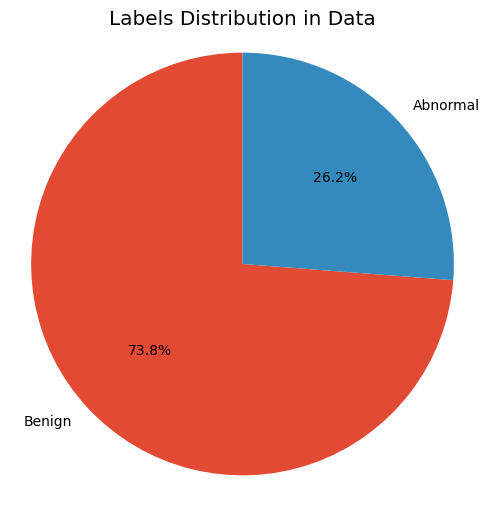

In [9]:
# plotting label counts
label_counts = df['Label'].value_counts()
labels = label_counts.index.tolist()
counts = label_counts.values.tolist()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Labels Distribution in Data')
plt.show()

In [10]:
df.info() #data inforation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8284195 entries, 0 to 8284194
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Flow Duration      int64  
 3   Tot Fwd Pkts       int64  
 4   Tot Bwd Pkts       int64  
 5   TotLen Fwd Pkts    int64  
 6   TotLen Bwd Pkts    float64
 7   Fwd Pkt Len Max    int64  
 8   Fwd Pkt Len Min    int64  
 9   Fwd Pkt Len Mean   float64
 10  Fwd Pkt Len Std    float64
 11  Bwd Pkt Len Max    int64  
 12  Bwd Pkt Len Min    int64  
 13  Bwd Pkt Len Mean   float64
 14  Bwd Pkt Len Std    float64
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float64
 17  Flow IAT Mean      float64
 18  Flow IAT Std       float64
 19  Flow IAT Max       float64
 20  Flow IAT Min       float64
 21  Fwd IAT Tot        float64
 22  Fwd IAT Mean       float64
 23  Fwd IAT Std        float64
 24  Fwd IAT Max        float64
 25  Fwd IAT Min       

In [11]:
df.replace([np.inf, - np.inf], np.nan, inplace = True) #replacing positive and negative infinity values to nans;

In [12]:
df.describe().T #statistical description

,count,mean,std,min,25%,50%,75%,max
Dst Port,8284195.0,1.089125e+04,2.022955e+04,0.000000e+00,53.0,80.0,3389.0,6.553500e+04
Protocol,8284195.0,8.169609e+00,4.507562e+00,0.000000e+00,6.0,6.0,6.0,1.700000e+01
Flow Duration,8284195.0,1.016396e+07,6.907962e+08,-9.190110e+11,518.0,13283.0,2698001.0,1.200000e+08
Tot Fwd Pkts,8284195.0,2.981951e+01,1.745906e+03,1.000000e+00,1.0,2.0,5.0,3.096290e+05
Tot Bwd Pkts,8284195.0,5.928527e+00,1.695580e+02,0.000000e+00,0.0,1.0,4.0,1.231180e+05
...,...,...,...,...,...,...,...,...
Active Min,8284195.0,6.362908e+04,1.269661e+06,0.000000e+00,0.0,0.0,0.0,1.140000e+08
Idle Mean,8284195.0,4.865523e+06,3.682925e+08,0.000000e+00,0.0,0.0,0.0,3.955714e+11
Idle Std,8284195.0,3.887613e+05,2.368278e+08,0.000000e+00,0.0,0.0,0.0,2.622479e+11
Idle Max,8284195.0,5.529347e+06,8.752748e+08,0.000000e+00,0.0,0.0,0.0,9.797810e+11


In [13]:
df.dropna(inplace=True) #dropping nans

#### **Data Preparation for Autoencoders**

In [14]:
# Select 'Normal' samples for training
normal_df = df[df['Label'] == 'Benign']
# Drop the 'Lable' column as we don't need it for training
normal_df = normal_df.drop('Label', axis=1)


In [15]:
normal_df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
2172044,443,6,94658,6,7,708,3718.0,387,0,118.0,...,3,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2172045,443,6,206,2,0,0,0.0,0,0,0.0,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2172046,445,6,165505,3,1,0,0.0,0,0,0.0,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2172047,443,6,102429,6,7,708,3718.0,387,0,118.0,...,3,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2172048,443,6,167,2,0,0,0.0,0,0,0.0,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8284190,53,17,61898,2,2,78,254.0,39,39,39.0,...,1,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8284191,1500,6,86213373,2,0,0,0.0,0,0,0.0,...,0,20,0.0,0.0,0.0,0.0,86213373.0,0.0,86213373.0,86213373.0
8284192,53,17,642,1,1,39,67.0,39,39,39.0,...,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8284193,53,17,78472,1,1,32,121.0,32,32,32.0,...,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Prepare Test set
test_set = pd.DataFrame(columns=df.columns)  # Create an empty dataframe with the same columns for testing purposes

# Sample 5000 instances of 'benign' and append to the new dataframe
benign_samples = df[df['Label'] == 'Benign'].sample(n=500000, replace=True)
test_set = pd.concat([test_set, benign_samples])

# Sample 5000 instances of 'abnormal' and append to the new dataframe
abnormal_samples = df[df['Label'] == 'Abnormal'].sample(n=100000, replace=True)
test_set = pd.concat([test_set, abnormal_samples])

# Reset the index of the new dataframe
test_set = test_set.reset_index(drop=True)

y_test = pd.DataFrame(test_set['Label']) # Create a new dataframe from the 'Label' column
test_set = test_set.drop('Label', axis=1)


Here, I've takken a larger number of Beningn Samples (0.5 Million Instances) and Abnormal Samples (0.1 Million Instances) to create a testing set for the model to test on and get a confusion matrix to show the results.

In [17]:
test_set

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,52226,6,27,1,1,0,0.0,0,0,0.000000,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,53,17,421,1,1,46,62.0,46,46,46.000000,...,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,17,386,1,1,84,212.0,84,84,84.000000,...,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,80,6,6407457,4,4,97,231.0,97,0,24.250000,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3389,6,1755110,10,7,673,301.0,187,0,67.300000,...,6,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,80,6,1490,2,0,0,0.0,0,0,0.000000,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599996,8080,6,499,2,0,0,0.0,0,0,0.000000,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599997,22,6,382807,22,20,1912,2665.0,640,0,86.909091,...,16,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599998,80,6,23950,3,4,340,935.0,340,0,113.333333,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Normalize  data
scaler = StandardScaler()
normal_df = scaler.fit_transform(normal_df)

In [19]:
test_set = scaler.transform(test_set)


### **Autoencoders in Action**

In [20]:
input_dim = normal_df.shape[1]  # Number of features
encoding_dim = 14  

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(normal_df, normal_df,
                          epochs=10,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2)

2023-07-07 10:39:31.187633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
151929/151929 [==============================] - 438s 3ms/step - loss: 0.6094 - val_loss: 1.0106
Epoch 2/10
151929/151929 [==============================] - 569s 4ms/step - loss: 0.6080 - val_loss: 1.0106
Epoch 3/10
151929/151929 [==============================] - 464s 3ms/step - loss: 0.6080 - val_loss: 1.0105
Epoch 4/10
151929/151929 [==============================] - 472s 3ms/step - loss: 0.6080 - val_loss: 1.0105
Epoch 5/10
151929/151929 [==============================] - 459s 3ms/step - loss: 0.6079 - val_loss: 1.0105
Epoch 6/10
151929/151929 [==============================] - 445s 3ms/step - loss: 0.6079 - val_loss: 1.0105
Epoch 7/10
151929/151929 [==============================] - 392s 3ms/step - loss: 0.6079 - val_loss: 1.0105
Epoch 8/10
151929/151929 [==============================] - 428s 3ms/step - loss: 0.6079 - val_loss: 1.0105
Epoch 9/10
151929/151929 [==============================] - 414s 3ms/step - loss: 0.6079 - val_loss: 1.0105
Epoch 10/10
151929/151929 [=

### **Evaluation**
Evaluate the model by calculating the reconstruction error on the test set.

In [21]:
predictions = autoencoder.predict(test_set)
mse = np.mean(np.power(test_set - predictions, 2), axis=1)

18750/18750 [==============================] - 34s 2ms/step


In [22]:
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test['Label']})

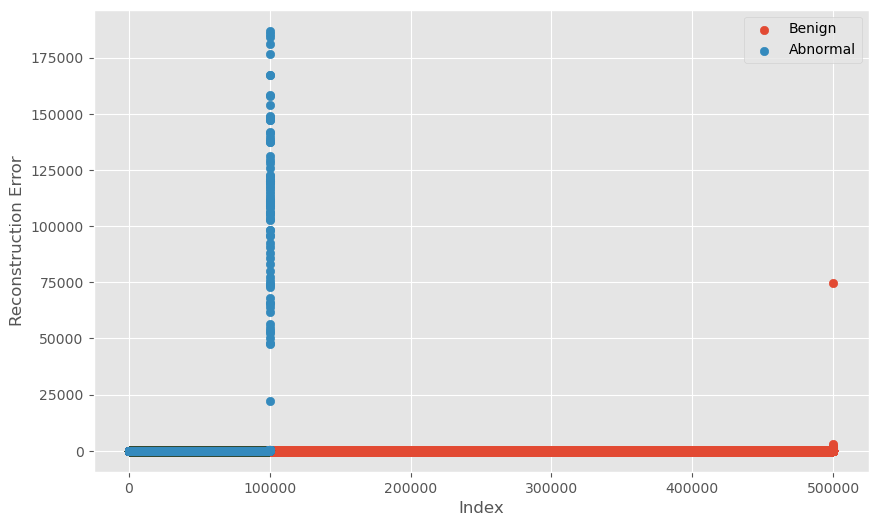

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(range(error_df[error_df['True_class']=='Benign'].shape[0]), 
            np.sort(error_df[error_df['True_class']=='Benign']['Reconstruction_error'].values), 
            label='Benign')
plt.scatter(range(error_df[error_df['True_class']=='Abnormal'].shape[0]), 
            np.sort(error_df[error_df['True_class']=='Abnormal']['Reconstruction_error'].values), 
            label='Abnormal')
plt.xlabel('Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


This scatter plot shows that Higher percentage of the Benign Instance, normal_df was correctly identified with zero reconstruction error, but also, most of the Abnormal instances were also identified as normal instance instead of being abnormal due to very low reconstruction error. But despite the model was trained on only normal data, It was able to identify a large number of attacks as anomalies.

#### **Anomaly Threshold**
We can decide on a threshold for the reconstruction error, above which a data point will be considered an 'Attack'. This threshold could be determined based on understanding of the data or simply we can use an approach like a certain percentile of the error in the normal samples.

In [59]:
threshold = np.percentile(error_df.Reconstruction_error.values, 95)  # Adjust percentile value according to the distribution

#### **Prediction and Performance**
Finally, Lets predict the labels (Normal or Attack) based on our trained autoencoder model and chosen threshold.

In [51]:
y_test['Label'].value_counts()

Benign      500000
Abnormal    100000
Name: Label, dtype: int64

In [60]:
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]

In [61]:
# Convert original 'Lable' to binary format
binary_y = [0 if l == 'Benign' else 1 for l in y_test['Label']] # Benign = 0, Abnormal = 1

In [62]:
binary_y_series = pd.Series(binary_y)
print(binary_y_series.value_counts())


0    500000
1    100000
dtype: int64


In [63]:
print(classification_report(binary_y, pred_y))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90    500000
           1       0.38      0.11      0.17    100000

    accuracy                           0.82    600000
   macro avg       0.61      0.54      0.54    600000
weighted avg       0.77      0.82      0.78    600000



In [64]:
def print_metrics(y_true, y_pred):
    print('Accuracy:', metrics.accuracy_score(y_true, y_pred))
    print('Precision:', metrics.precision_score(y_true, y_pred))
    print('Recall:', metrics.recall_score(y_true, y_pred))
    print('F1 Score:', metrics.f1_score(y_true, y_pred))
    
print_metrics(binary_y, pred_y)

Accuracy: 0.8212066666666666
Precision: 0.3787333333333333
Recall: 0.11362
F1 Score: 0.17479999999999998


In [65]:
# Compute confusion matrix
cm = confusion_matrix(binary_y, pred_y)
print(cm)

[[481362  18638]
 [ 88638  11362]]


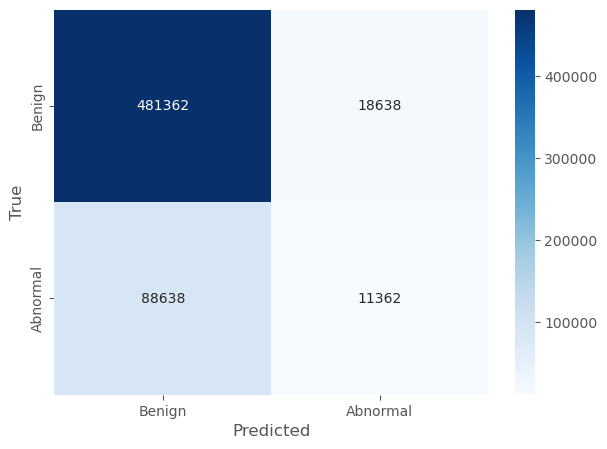

In [66]:
# Plot confusion matrix with seaborn
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
class_labels = ['Benign', 'Abnormal']
# Set x-axis labels
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel('Predicted')
# Set y-axis labels
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.ylabel('True')
plt.show()